In [1]:
from contra_qa.text_generation.boolean3_NP_and import boolean3
from contra_qa.text_generation.boolean4_VP_and import boolean4
from contra_qa.text_generation.boolean5_AP_and import boolean5
from contra_qa.text_processing.functions import simple_pre_process_text_df
from contra_qa.plots.functions  import plot_histogram_from_labels

from contra_qa.train_functions.RNNConfig import RNNConfig
import numpy as np
import torch
import torch.nn as nn
from torchtext import data

import pandas as pd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

% matplotlib inline

creating datasets

In [2]:
boolean3()
# boolean4()
# boolean5()

In [3]:
df3 = pd.read_csv("data/boolean3_train.csv") 

In [4]:
df3.head()

,sentence1,sentence2,and_A,and_B,label
0,Jamie and Lindsey went to Slatina,Brandi didn't go to Slatina,Jamie went to Slatina,Lindsey went to Slatina,0
1,Mary and Mathew have visited Turda,Mary didn't visit Turda,Mary has visited Turda,Mathew has visited Turda,1
2,Clinton went to Blaj and Lugoj,Clinton didn't go to Blaj,Clinton went to Blaj,Clinton went to Lugoj,1
3,Amy and Maria went to Tulcea,Eddie didn't go to Tulcea,Amy went to Tulcea,Maria went to Tulcea,0
4,Heidi and April went to Hunedoara,Stacey didn't go to Hunedoara,Heidi went to Hunedoara,April went to Hunedoara,0


In [5]:
simple_pre_process_text_df(df3, "sentence1")
simple_pre_process_text_df(df3, "sentence2")
simple_pre_process_text_df(df3, "and_A")
simple_pre_process_text_df(df3, "and_B")

df3["text"] = df3["sentence1"] + ", " + df3["sentence2"]

In [6]:
df3.head()

,sentence1,sentence2,and_A,and_B,label,text
0,jamie and lindsey went to slatina,brandi didnt go to slatina,jamie went to slatina,lindsey went to slatina,0,"jamie and lindsey went to slatina, brandi didn..."
1,mary and mathew have visited turda,mary didnt visit turda,mary has visited turda,mathew has visited turda,1,"mary and mathew have visited turda, mary didnt..."
2,clinton went to blaj and lugoj,clinton didnt go to blaj,clinton went to blaj,clinton went to lugoj,1,"clinton went to blaj and lugoj, clinton didnt ..."
3,amy and maria went to tulcea,eddie didnt go to tulcea,amy went to tulcea,maria went to tulcea,0,"amy and maria went to tulcea, eddie didnt go t..."
4,heidi and april went to hunedoara,stacey didnt go to hunedoara,heidi went to hunedoara,april went to hunedoara,0,"heidi and april went to hunedoara, stacey didn..."


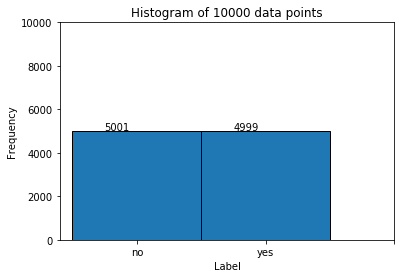

In [7]:
plot_histogram_from_labels(df3.label.values, ["no", "yes"], "test.png") 

In [8]:
df3_little = df3[["text", "label"]]

In [9]:
df3_little.head()

,text,label
0,"jamie and lindsey went to slatina, brandi didn...",0
1,"mary and mathew have visited turda, mary didnt...",1
2,"clinton went to blaj and lugoj, clinton didnt ...",1
3,"amy and maria went to tulcea, eddie didnt go t...",0
4,"heidi and april went to hunedoara, stacey didn...",0


In [10]:
train_data_path = "data/boolean_3_train_lab.csv"

df3_little.to_csv(train_data_path, header=False, index=False)

In [11]:
TEXT = data.Field()
LABEL = data.LabelField(tensor_type=torch.FloatTensor)
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

In [12]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [13]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 708
len(LABEL.vocab): 2


In [14]:
df3_little.head()

,text,label
0,"jamie and lindsey went to slatina, brandi didn...",0
1,"mary and mathew have visited turda, mary didnt...",1
2,"clinton went to blaj and lugoj, clinton didnt ...",1
3,"amy and maria went to tulcea, eddie didnt go t...",0
4,"heidi and april went to hunedoara, stacey didn...",0


In [15]:
df3.head()

,sentence1,sentence2,and_A,and_B,label,text
0,jamie and lindsey went to slatina,brandi didnt go to slatina,jamie went to slatina,lindsey went to slatina,0,"jamie and lindsey went to slatina, brandi didn..."
1,mary and mathew have visited turda,mary didnt visit turda,mary has visited turda,mathew has visited turda,1,"mary and mathew have visited turda, mary didnt..."
2,clinton went to blaj and lugoj,clinton didnt go to blaj,clinton went to blaj,clinton went to lugoj,1,"clinton went to blaj and lugoj, clinton didnt ..."
3,amy and maria went to tulcea,eddie didnt go to tulcea,amy went to tulcea,maria went to tulcea,0,"amy and maria went to tulcea, eddie didnt go t..."
4,heidi and april went to hunedoara,stacey didnt go to hunedoara,heidi went to hunedoara,april went to hunedoara,0,"heidi and april went to hunedoara, stacey didn..."


In [16]:
exampleS1 = list(df3.sentence1.values)[0:3]
exampleS2 = list(df3.sentence2.values)[0:3]
exampleA = list(df3.and_A.values)[0:3]
exampleB = list(df3.and_B.values)[0:3]
exampleLabel = list(df3.label.values)[0:3]

In [17]:
def finde_size(list_):
    return np.max(list(map(lambda x: len(x.split(" ")), list_)))

In [18]:
exampleS1i = []
max_size = finde_size(exampleS1)
for line in exampleS1:
    line = line.split(" ")
    size = len(line) 
    tail = max_size - size
    line += [TEXT.pad_token] * tail
    new_line = [TEXT.vocab.stoi[word] for word in line]
    exampleS1i.append(new_line)
exampleS1i = torch.tensor(exampleS1i, dtype=torch.long, device=device)
for a,b in zip(exampleS1, exampleS1i):
    print(a)
    print(b, len(b))
    print()

jamie and lindsey went to slatina
tensor([ 54,   3, 614,   7,   2,  17]) 6

mary and mathew have visited turda
tensor([506,   3,  68,  12,   9,  25]) 6

clinton went to blaj and lugoj
tensor([553,   7,   2,  21,   3,  22]) 6



In [19]:
exampleS2i = []
max_size = finde_size(exampleS2)
for line in exampleS2:
    line = line.split(" ")
    size = len(line) 
    tail = max_size - size
    line += [TEXT.pad_token] * tail
    new_line = [TEXT.vocab.stoi[word] for word in line]
    exampleS2i.append(new_line)

exampleS2i = torch.tensor(exampleS2i, dtype=torch.long, device=device)
for a,b in zip(exampleS2, exampleS2i):
    print(a)
    print(b, len(b))
    print()

brandi didnt go to slatina
tensor([71,  4,  6,  2, 17]) 5

mary didnt visit turda
tensor([506,   4,   8,  25,   1]) 5

clinton didnt go to blaj
tensor([553,   4,   6,   2,  21]) 5



In [20]:
exampleAi = []
max_size = finde_size(exampleA)
for line in exampleA:
    line = line.split(" ")
    size = len(line) 
    tail = max_size - size
    line += [TEXT.pad_token] * tail
    new_line = [TEXT.vocab.stoi[word] for word in line]
    exampleAi.append(new_line)
    
exampleAi = torch.tensor(exampleAi, dtype=torch.long, device=device)
for a,b in zip(exampleA, exampleAi):
    print(a)
    print(b, len(b))
    print()

jamie went to slatina
tensor([54,  7,  2, 17]) 4

mary has visited turda
tensor([506,   5,   9,  25]) 4

clinton went to blaj
tensor([553,   7,   2,  21]) 4



In [21]:
exampleBi = []
max_size = finde_size(exampleB)
for line in exampleB:
    line = line.split(" ")
    size = len(line) 
    tail = max_size - size
    line += [TEXT.pad_token] * tail
    new_line = [TEXT.vocab.stoi[word] for word in line]
    exampleBi.append(new_line)

exampleBi = torch.tensor(exampleBi, dtype=torch.long, device=device)
for a,b in zip(exampleB, exampleBi):
    print(a)
    print(b, len(b))
    print()

lindsey went to slatina
tensor([614,   7,   2,  17]) 4

mathew has visited turda
tensor([68,  5,  9, 25]) 4

clinton went to lugoj
tensor([553,   7,   2,  22]) 4



In [22]:
s1 = exampleS1i[0]
s2 = exampleS2i[0]
and_a = exampleAi[0]
and_b = exampleBi[0]

In [23]:
exampleS1i_t  = exampleS1i.view((exampleS1i.shape[1], exampleS1i.shape[0]))
exampleS2i_t  = exampleS2i.view((exampleS2i.shape[1], exampleS2i.shape[0]))
exampleAi_t  = exampleAi.view((exampleAi.shape[1], exampleAi.shape[0]))
exampleBi_t  = exampleBi.view((exampleBi.shape[1], exampleBi.shape[0]))
exampleLabeli = torch.tensor(exampleLabel, dtype=torch.long, device=device)

In [24]:
class AddRNN(nn.Module):
    def __init__(self,
                 vocab_size,
                 hidden_size,
                 output_size):
        super(AddRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size) 
        self.fcA = nn.Linear(hidden_size, hidden_size)
        self.fcB = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
#         self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        
        
    def encode(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros((1, x.shape[1], self.hidden_size), device=device)
        embedded = self.embedding(x)       
        output, hidden = self.rnn(embedded, hidden)
        hidden = hidden.squeeze(0)
        return hidden

    def forward(self, s1, s2):
        h = self.encode(s1)
        ha = self.fcA(h)
        hb = self.fcB(h)
        h_inf = ha + hb
#         h_inf = ha * hb
#         h_inf = self.fc_inf(torch.cat([ha, hb], dim=1))
        h_inf = h_inf.view((1, h_inf.shape[0], h_inf.shape[1]))
        s2_enc = self.encode(s2, h_inf)
        out = self.fc_out(s2_enc)
        return out



In [25]:
model = AddRNN(vocab_size=len(TEXT.vocab),
               hidden_size=10,
               output_size=2)

out = model(exampleS1i_t, exampleS2i_t)

In [26]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(exampleS1i, exampleS2i, exampleAi, exampleBi, exampleLabeli)
valid_dataset = TensorDataset(exampleS1i, exampleS2i, exampleAi, exampleBi, exampleLabeli)
test_dataset = TensorDataset(exampleS1i, exampleS2i, exampleAi, exampleBi, exampleLabeli)

In [27]:
from torch.utils.data import DataLoader

class DataHolderGentle():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)

In [28]:
config = RNNConfig()
b_data = DataHolderGentle(config,
                          train_dataset,
                          valid_dataset,
                          test_dataset)

In [29]:
next(iter(b_data.train_loader))

[tensor([[553,   7,   2,  21,   3,  22],
         [506,   3,  68,  12,   9,  25],
         [ 54,   3, 614,   7,   2,  17]]), tensor([[553,   4,   6,   2,  21],
         [506,   4,   8,  25,   1],
         [ 71,   4,   6,   2,  17]]), tensor([[553,   7,   2,  21],
         [506,   5,   9,  25],
         [ 54,   7,   2,  17]]), tensor([[553,   7,   2,  22],
         [ 68,   5,   9,  25],
         [614,   7,   2,  17]]), tensor([1, 1, 0])]